# Investigating the Lyman Break over Cosmic Time

### Notebook Author: Mitchell Hooymans

This activity is heavily inspired by the work in Sameul Wait's Honours Thesis: 'Traversing the Cosmic Timeline: Exploring Distant Galaxies with the Lyman Break Technique'. This activity intends to go over the basics of the Lyman Break technique and attempt to recreate some of the results from Wait's thesis. In this activity SED templates of galaxies at different redshifts will be created and the Lyman Break will be investigated. Additionally the Lyman Break will also be used on an observational data set to confirm the results. The observational data set used in this activity is the ZFOURGE survey.

The Lyman Break Technique is a powerful astronomical method used to identify and study distant galaxies based on the absorption characteristics of neutral hydrogen gas. Hydrogen gas, the most abundant element in the universe, has a specific ionization energy of $13.6$ electron volts (eV). When a photon with at least this energy interacts with a hydrogen atom, it can lead to ionization. Converting this ionization energy to SI units gives approximately $2.18 \times 10^{-18}$ joules. By further converting this energy to the corresponding wavelength using the formula $\lambda = \frac{hc}{E}$, where $h$ is Planck's constant and $c$ is the speed of light, a wavelength of $912 \, \text{Å}$ (Angstroms) is obtained, known as the Lyman limit.

In the rest frame of the atom being ionized, light with a wavelength equal to or shorter than $912 \, \text{Å}$ is strongly absorbed during the photoionization process, resulting in a distinct decrease in continuum flux below this threshold in the spectral energy distribution (SED) of galaxies, a phenomenon referred to as the 'Lyman Dropout.' However, due to the expansion of the universe, the originally absorbed light is redshifted as it travels through space, altering its wavelength according to the formula $\lambda_s = \lambda \cdot (1 + z)$, where $z$ represents the redshift. The position of the Lyman Dropout wavelength ($\lambda_s$) can be used to estimate the redshift ($z$) of the galaxy, providing crucial information about its distance and age. Higher redshift values correspond to more distant galaxies, revealing insights into the evolution of the universe over time.


<div style="display: flex; justify-content: space-between;">
  <img src="LymanDropoutExample.png" alt="Example 1: Lyman Dropout at 912A" style="width: 48%;">
  <img src="LymanDropoutRedshiftsExample.png" alt="Example 2: Lyman Dropout at Varying Cosmological Redshifts" style="width: 48%;">
</div>

Above we see an example SED of the Lyman Droupout occuring at 912 Å. The Lyman Break is the steep drop in flux at this wavelength. The Lyman Break is a powerful tool for identifying high redshift galaxies. In addition we also see an example of Dropout Wavelength vs Redshift. 

Image Credits: Samuel Wait

In [243]:
# Begin by Importing all of the required libraries.
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
import pandas as pd
import os
from astLib import astSED
import astropy.io.fits as fits

## Part 1: Investigating Redshift Determination using the ZFOURGE COSMOS data set
Redshift determination is to be recreated using the the method outlined by Giavalisco in their 2002 paper, Lyman Break Galaxies. The ZFOURGE COSMOS data set will be used to recreate the results. This dataset is used as they contain a U, G, and R filters with similar profiles to the filters used by Giavalisco.


In [244]:
# Begin by importing the cosmos field data, including the rest, zout, and fout data.
cosmos_filename = os.path.join('datasets', 'zfourge', 'cosmos.v1.3.8.cat')
cosmos_zout_filename = os.path.join('datasets', 'zfourge', 'cosmos.v1.3.6.zout')
cosmos_rest_filename = os.path.join('datasets', 'zfourge', 'cosmos.v1.3.6.rest.v0.9.cat')
cosmos_fout_filename = os.path.join('datasets', 'zfourge', 'cosmos.v1.3.6.fout')


cosmos_cat = np.genfromtxt(cosmos_filename, names=True, dtype=None, encoding='ascii')
cosmos_zout = np.genfromtxt(cosmos_zout_filename, names=True, dtype=None, encoding='ascii')
cosmos_rest = np.genfromtxt(cosmos_rest_filename, names=True, dtype=None, encoding='ascii', skip_header=22)
cosmos_fout = np.genfromtxt(cosmos_fout_filename, names=True, dtype=None, encoding='ascii')

In [245]:
# Use pandas dataframes for easier manipulation of the datasets.
cosmos_cat = pd.DataFrame(cosmos_cat)
cosmos_zout = pd.DataFrame(cosmos_zout)
cosmos_fout = pd.DataFrame(cosmos_fout)
cosmos_rest = pd.DataFrame(cosmos_rest)

# change f_U, f_V, f_J to rf_U, rf_V, rf_J - where r indicates rest frame
cosmos_rest.rename(columns={'f_U': 'rf_U', 'f_V': 'rf_V', 'f_J': 'rf_J'}, inplace=True)

# join all dataframes together - include important columns from each dataframe
cosmos_df = pd.merge(cosmos_cat, cosmos_zout[['id', 'z_peak']], on='id')
cosmos_df = pd.merge(cosmos_df, cosmos_rest[['id', 'rf_U', 'rf_V', 'rf_J']], on='id')
cosmos_df = pd.merge(cosmos_df, cosmos_fout[['id', 'lmass', 'lssfr']])

# Use only the data that has been selected as useable by the ZFOURGE team.
cosmos_df = cosmos_df[cosmos_df['use'] == 1]

# We would also like to filter out any data that has an error less than 5sigma or a flux less than 0 in the UGRI bands
sigma = 1
conditions_1 = (cosmos_df['f_U'] > 0) & (cosmos_df['f_G'] > 0) & (cosmos_df['f_R'] > 0) & (cosmos_df['f_I'] > 0)
#conditions_2 = (cosmos_df['f_U'] >= sigma * cosmos_df['e_U']) & (cosmos_df['f_G'] >= sigma * cosmos_df['e_G']) & (cosmos_df['f_R'] >= sigma * cosmos_df['e_R']) & (cosmos_df['f_I'] >= sigma * cosmos_df['e_I'])
cosmos_df = cosmos_df[conditions_1] #& conditions_2]







In [246]:
# We need to first convert the fluxes to magnitudes.
# We can do this using the following formula: m = -2.5 * log10(f) + 25
def flux_to_mag(flux):
    return -2.5 * np.log10(flux) + 25


# Convert all the fluxes into magnitudes for the U, G, R, and I bands
cosmos_df['u_mag'] = flux_to_mag(cosmos_df['f_U'])
cosmos_df['g_mag'] = flux_to_mag(cosmos_df['f_G'])
cosmos_df['r_mag'] = flux_to_mag(cosmos_df['f_R'])
cosmos_df['i_mag'] = flux_to_mag(cosmos_df['f_I'])

# additionally we can get the redshift and i
redshift = cosmos_df['z_peak']
cosmos_id = cosmos_df['id']

In [247]:
# How many galaxies are being used in this dataset
print(f'There are {len(cosmos_df)} galaxies in the cosmos dataset that are useable.')

There are 12003 galaxies in the cosmos dataset that are useable.


Text(0.5, 1.0, 'UGR Diagram for the COSMOS Field')

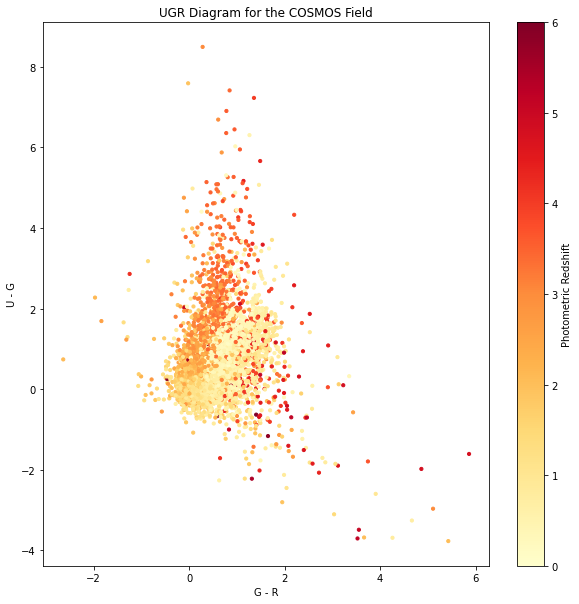

In [248]:
# Plot the UGR data for the cosmos field according to Giavalisco's 2002 paper. # GRI filterset can be used for high redshift windows between 3.8 and 5.0
figure = plt.figure(figsize=(10, 10))

# colour indices
ug = cosmos_df['u_mag'] - cosmos_df['g_mag']
gr = cosmos_df['g_mag'] - cosmos_df['r_mag']


plt.scatter(gr, ug, c=redshift, cmap='YlOrRd', s=10)
plt.clim(0, 6)
plt.colorbar(label='Photometric Redshift')
plt.ylabel('U - G')
plt.xlabel('G - R')
plt.title('UGR Diagram for the COSMOS Field')

Text(0.5, 1.0, 'GRI Diagram for the COSMOS Field')

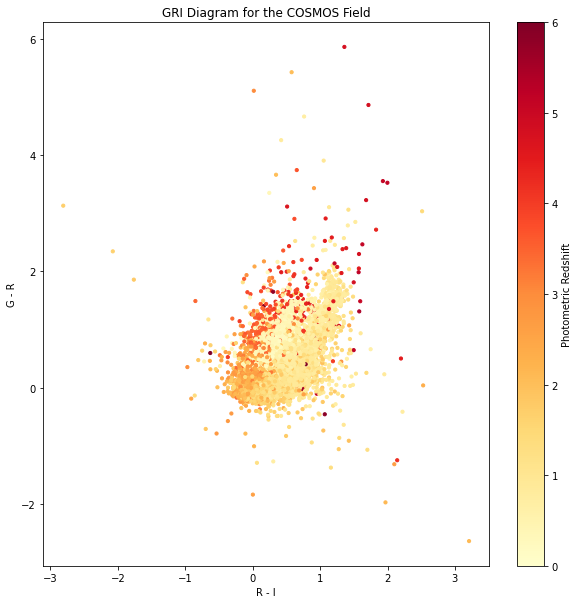

In [249]:
# Likewise for completeness we plot a GRI diagram for the cosmos field, for exploring G band selection at redshifts of 3.8 to 5.0
figure = plt.figure(figsize=(10, 10))

# colour indices - reuse gr from before
ri = cosmos_df['r_mag'] - cosmos_df['i_mag']

plt.scatter(ri, gr, c=redshift, cmap='YlOrRd', s=10)
plt.clim(0, 6)
plt.colorbar(label='Photometric Redshift')
plt.ylabel('G - R')
plt.xlabel('R - I')
plt.title('GRI Diagram for the COSMOS Field')


### Part 1.1 Exploring the Giavalisco Technique
The Giavalisco selection reigon is overlayed on top of the ZFOURGE COSMOS data set. The selection reigon is defined by the following criteria:

$(U - G) \geq 1 + (G - R)$ ; $(U - G) \geq 1.6 $ ; $ (G - R) \leq 1.2$

This criteria is used to bin galaxies into an expected redshift range of $2.6 < z < 3.6$.


Additionally but not explicitly required we also include the Givalisco technique for higher redshifts of $3.8 < z < 5.0$:

$(G - R) \geq 2 $ ; $(G - R) \geq 2 \times (R - I) + 1.5$ ; $(R - I) \leq 0.6$



In [250]:
# Define the selection criteria
giavalisco_selection_ugr = ((ug >= (1 + gr)) & (ug >= 1.6) & (gr <= 1.2))
giavalisco_selection_gri = ((gr >= 2.0) & (gr >= 2 * ri + 1.5) & (ri <= 0.6))


Text(0.5, 1.0, 'Giavalisco U Dropout Selection for the COSMOS Field')

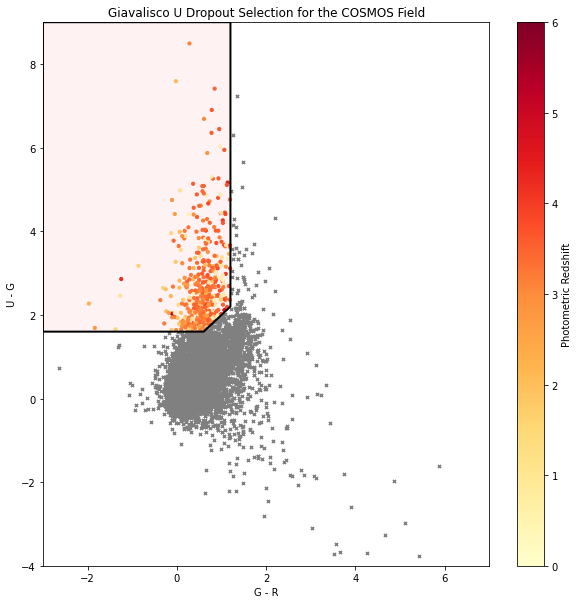

In [251]:
# plot the relevant selections - U dropout
plt.figure(figsize=(10, 10))
plt.scatter(gr[giavalisco_selection_ugr], ug[giavalisco_selection_ugr], c=redshift[giavalisco_selection_ugr], cmap='YlOrRd', s=10)




plt.xlim(-3, 7)
plt.ylim(-4, 9)

plt.clim(0, 6)
plt.colorbar(label='Photometric Redshift')
plt.scatter(gr[~giavalisco_selection_ugr], ug[~giavalisco_selection_ugr], color='grey', s=10, marker='x')
U_rule = [[1.2,9], [1.2,2.2], [0.6,1.6], [-3,1.6], [-3,9]]
plt.gca().add_patch(plt.Polygon(U_rule, closed=True, fill=True, facecolor=(1,0,0,0.05), edgecolor=(0,0,0,1), linewidth=2, linestyle='solid')) # This looks like the correct U dropout technique



plt.ylabel('U - G')
plt.xlabel('G - R')
plt.title('Giavalisco U Dropout Selection for the COSMOS Field')

Text(0.5, 1.0, 'Giavalisco G Dropout Selection for the COSMOS Field')

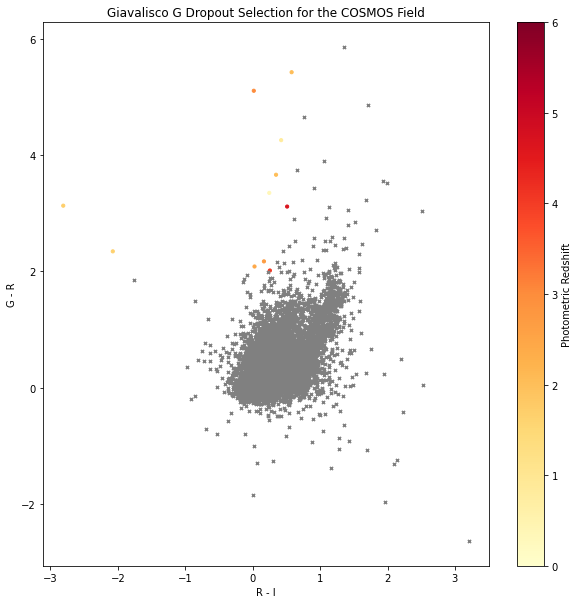

In [252]:
# Visualising the GRI selection -  G Dropout
plt.figure(figsize=(10, 10))
plt.scatter(ri[giavalisco_selection_gri], gr[giavalisco_selection_gri], c=redshift[giavalisco_selection_gri], cmap='YlOrRd', s=10)
plt.clim(0, 6)
plt.colorbar(label='Photometric Redshift')
plt.scatter(ri[~giavalisco_selection_gri], gr[~giavalisco_selection_gri], color='grey', s=10, marker='x')
plt.ylabel('G - R')
plt.xlabel('R - I')
plt.title('Giavalisco G Dropout Selection for the COSMOS Field')


In [253]:
# How many useable galaxies are selected by the UGR and GRI dropout criteria?
print(f'There are {np.sum(giavalisco_selection_ugr)} galaxies selected by the U dropout criteria.')
print(f'There are {np.sum(giavalisco_selection_gri)} galaxies selected by the G dropout criteria.')

There are 485 galaxies selected by the U dropout criteria.
There are 11 galaxies selected by the G dropout criteria.


698      3.1207
720      2.5680
728      2.0543
797      0.3649
819      2.6251
          ...  
20633    3.6652
20651    2.5669
20673    0.4222
20714    3.2422
20774    3.3873
Name: z_peak, Length: 485, dtype: float64

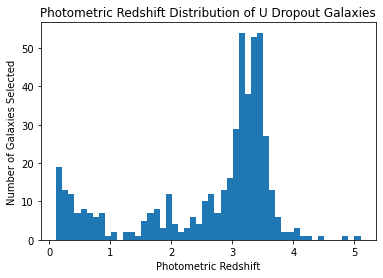

In [254]:
plt.hist(redshift[giavalisco_selection_ugr], bins=50)
plt.xlabel('Photometric Redshift')
plt.ylabel('Number of Galaxies Selected')
plt.title('Photometric Redshift Distribution of U Dropout Galaxies')

redshift[giavalisco_selection_ugr]

Text(0.5, 1.0, 'Photometric Redshift Distribution of G Dropout Galaxies')

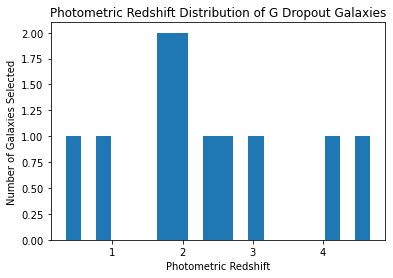

In [255]:
plt.hist(redshift[giavalisco_selection_gri], bins=20)
plt.xlabel('Photometric Redshift')
plt.ylabel('Number of Galaxies Selected')
plt.title('Photometric Redshift Distribution of G Dropout Galaxies') 

# The histogram indicates this doesn't work.

In [256]:
# Now we are using rest frame data to investigate properties of the selected galaxies.
# again we convert flux to AB magnitude
cosmos_df['rf_u_mag'] = flux_to_mag(cosmos_df['rf_U'])
cosmos_df['rf_v_mag'] = flux_to_mag(cosmos_df['rf_V'])
cosmos_df['rf_j_mag'] = flux_to_mag(cosmos_df['rf_J'])

# Colour Indicies for UVJ diagram
# uv = cosmos_df['rf_u_mag'] - cosmos_df['rf_v_mag']
# vj = cosmos_df['rf_v_mag'] - cosmos_df['rf_j_mag']




### Part 1.2 Categorising and Investigating Galaxy Selections
We now seperate the galaxies into 4 categories, disregarding the GRI selection results. The correct redshift range we are investigating is 2.6 - 3.6

The four classifications for the galaxies are as follows:
1. Selected, and in the correct redshift range - (correct selection)
2. Selected, but not in the correct redshift range - (incorrect selection)
3. Not selected, but in the correct redshift range - (missed selection)
4. Not selected, and not in the correct redshift range - (correct selection)

We can investigate the UGR colour space to see if the selection criteria is effective at identifying galaxies in the correct redshift range.

Text(0.5, 1.0, 'Photometric Redshift Distribution of U Dropout Galaxies')

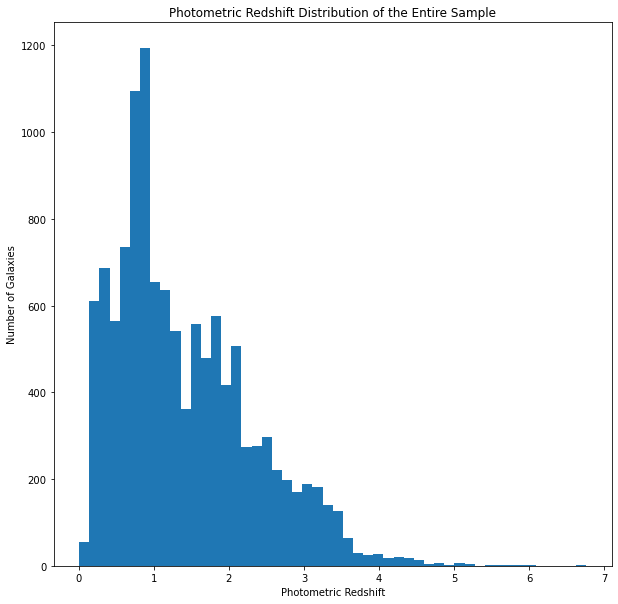

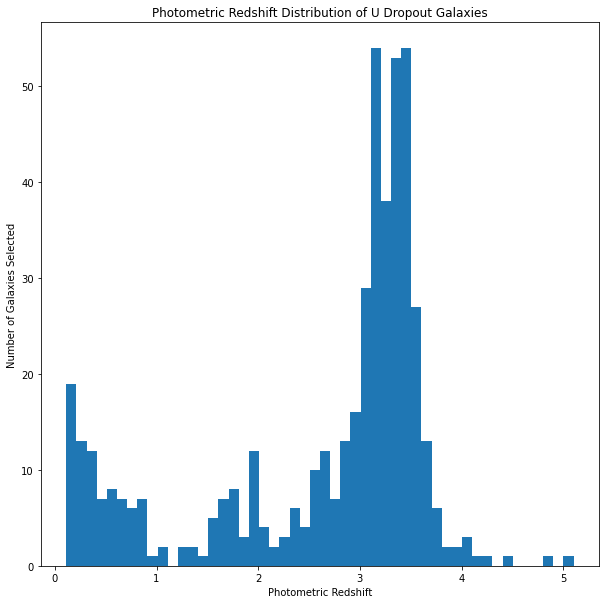

In [257]:
# Similarly we can plot the redshift histogram of the entire sample, and the u dropout candidates respectively
# Redshift distribution of the entire sample
plt.figure(figsize=(10, 10))
plt.hist(redshift, bins=50)
plt.xlabel('Photometric Redshift')
plt.ylabel('Number of Galaxies')
plt.title('Photometric Redshift Distribution of the Entire Sample')


# redshift distribution for the dropout candidates - including the misidentified and missed selection
plt.figure(figsize=(10, 10))
plt.hist(redshift[giavalisco_selection_ugr], bins=50)
plt.xlabel('Photometric Redshift')
plt.ylabel('Number of Galaxies Selected')
plt.title('Photometric Redshift Distribution of U Dropout Galaxies')


Text(0.5, 1.0, 'Giavalisco U Dropout Selection for the COSMOS Field')

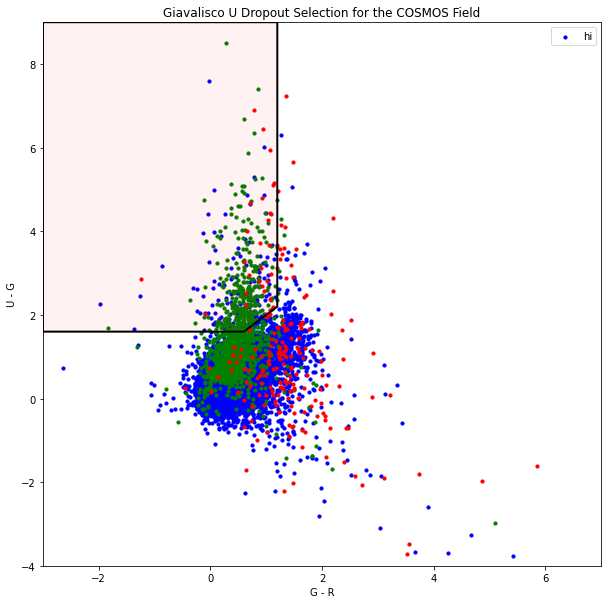

In [258]:
# We can investigate the redshift distribution of all galaxies in the sample over the UGR colour space - in bins of redshift: z <= 2.6, 2.6 < z < 3.6, z >= 3.6
plt.figure(figsize=(10, 10))


z_low = cosmos_df[redshift <= 2.6]
z_mid = cosmos_df[(redshift > 2.6) & (redshift < 3.6)]
z_high = cosmos_df[redshift >= 3.6]

# Now getting the colour axis
ug_low = z_low['u_mag'] - z_low['g_mag']
gr_low = z_low['g_mag'] - z_low['r_mag']

ug_mid = z_mid['u_mag'] - z_mid['g_mag']
gr_mid = z_mid['g_mag'] - z_mid['r_mag']

ug_high = z_high['u_mag'] - z_high['g_mag']
gr_high = z_high['g_mag'] - z_high['r_mag']

plt.scatter(gr_low, ug_low,label="hi" ,c='b', s=10)
plt.scatter(gr_mid, ug_mid, c='g', s=10)
plt.scatter(gr_high, ug_high, c='r', s=10)
plt.legend()
plt.xlim(-3, 7)
plt.ylim(-4, 9)
U_rule = [[1.2,9], [1.2,2.2], [0.6,1.6], [-3,1.6], [-3,9]]
plt.gca().add_patch(plt.Polygon(U_rule, closed=True, fill=True, facecolor=(1,0,0,0.05), edgecolor=(0,0,0,1), linewidth=2, linestyle='solid')) # This looks like the correct U dropout technique



plt.ylabel('U - G')
plt.xlabel('G - R')
plt.title('Giavalisco U Dropout Selection for the COSMOS Field')

In [259]:
# Seperating categories
# Correct Identification - ugr selection and correct redshift range, or correct non-ugr selection and correct redshift range (unselected)
correct_ugr_identification_df = cosmos_df[(giavalisco_selection_ugr & ((redshift >= 2.6) & (redshift <= 3.6)))]
correct_nonugr_identification_df = cosmos_df[(~giavalisco_selection_ugr & ((redshift < 2.6) | (redshift > 3.6)))]

# Misidentification - ugr selection and incorrect redshift range
misidentification_df = cosmos_df[(giavalisco_selection_ugr & ((redshift < 2.6) | (redshift > 3.6)))]

# Missed Selection - non-ugr selection and correct redshift range
missed_selection_df = cosmos_df[(~giavalisco_selection_ugr & ((redshift >= 2.6) & (redshift <= 3.6)))]


In [260]:
# Printing the number of galaxies in the inital sample - after filtering for useable data
print(f'Initial Sample: {len(cosmos_df)}')

# We can now sum up the numbers that we see in the historgrams to get a better idea of the distribution of mass for each category.
print(f'Correctly Identified: {len(correct_ugr_identification_df)}') # Within redshift range and in selection reigon
print(f'Correctly Unselected: {len(correct_nonugr_identification_df)}') # Outside redshift range and outside selection reigon
print(f'Misidentified: {len(misidentification_df)}') # Inside selection reigon but outside redshift range
print(f'Missed Selection: {len(missed_selection_df)}') # Inside redshift range but outside selection reigon

# printing this as a table where the columns are in redshift range, not in redshift range, and the rows are in selection reigon, and not in selection reigon
# Create a dictionary with the data
category_table = {'Redshift Range': ['In', 'Out'],
        'In Selection Region': [len(correct_ugr_identification_df), len(missed_selection_df)],
        'Out Selection Region': [len(misidentification_df), len(correct_nonugr_identification_df)]}

# Create a DataFrame from the dictionary
category_df = pd.DataFrame(category_table)

# Set the index to 'Redshift Range'
category_df.set_index('Redshift Range', inplace=True)



# Print the DataFrame to visualise the data
print("\n\n")
print(category_df)

Initial Sample: 12003
Correctly Identified: 305
Correctly Unselected: 10587
Misidentified: 180
Missed Selection: 931



                In Selection Region  Out Selection Region
Redshift Range                                           
In                              305                   180
Out                             931                 10587


In [261]:
# Define plotting code to plot the UVJ diagram for each of the outlined categories
def plot_uvj_categories(df, category):
    # Plotting the UVJ diagram for each of the identified categories
    plt.figure(figsize=(10, 10))

    # Colour Indicies
    uv = df['rf_u_mag'] - df['rf_v_mag']
    vj = df['rf_v_mag'] - df['rf_j_mag']

    # use the starforming rate as the colour map
    log_sfr = df['lssfr']

    plt.scatter(vj, uv, s=10, label= category+ ' UGR Galaxies', c=log_sfr, cmap='RdYlBu')
    plt.ylabel('U - V')
    plt.xlabel('V - J')
    plt.title('UVJ Diagram for '+ category +' UGR Galaxies')
    plt.xlim([-0.5,2.2])
    plt.axes.line_width = 4
    plt.ylim([0,2.5])
    plt.clim(-11., -8.)
    plt.colorbar(label='log[sSFR (yr$^{-1}$)]')

    # We can use code to make patch selections on the UVJ diagram, selecting Quiescent, Star-forming, and Dusty Galaxies
    # We use the paths as provided below to make the selections.
    path_quiescent = [[-0.5, 1.3],
                    [0.85, 1.3],
                    [1.6, 1.95],
                    [1.6, 2.5],
                    [-0.5, 2.5]]

    path_sf = [[-0.5, 0.0],
            [-0.5, 1.3],
            [0.85, 1.3],
            [1.2, 1.60333],
            [1.2, 0.0]]

    path_sfd = [[1.2, 0.0],
                [1.2, 1.60333],
                [1.6, 1.95],
                [1.6, 2.5],
                [2.2, 2.5],
                [2.2, 0.0]]

    plt.gca().add_patch(plt.Polygon(path_quiescent, closed=True, fill=True, facecolor=(1, 0, 0, 0.03),edgecolor='k', linewidth=2, linestyle='solid'))
    plt.gca().add_patch(plt.Polygon(path_sf, closed=True, fill=True, facecolor=(0, 0, 1, 0.03)))
    plt.gca().add_patch(plt.Polygon(path_sfd, closed=True, fill=True, facecolor=(1, 1, 0, 0.03)))

    plt.axvline(1.2, color='black', linestyle='--', ymin=0, ymax=1.60333/2.5) 


    plt.annotate('Quiescent', (-0.4, 2.4), color='black')
    plt.annotate('Star-forming', (-0.4, 1.2), color='black')
    plt.annotate('Dusty', (1.95, 2.4), color='black')

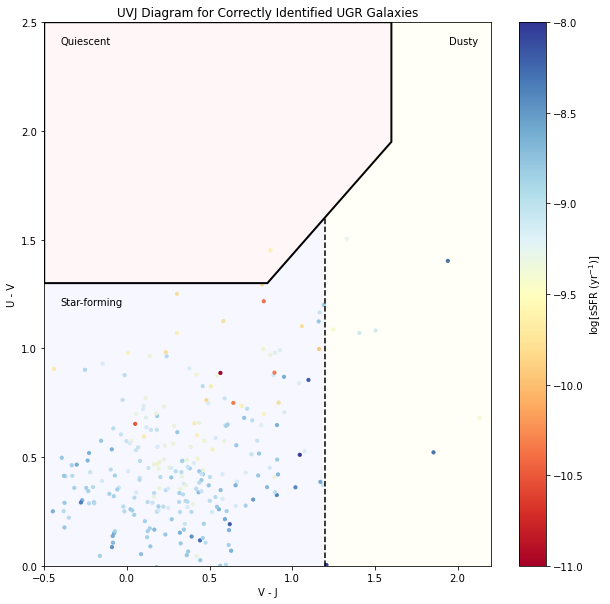

In [262]:
plot_uvj_categories(correct_ugr_identification_df, 'Correctly Identified')


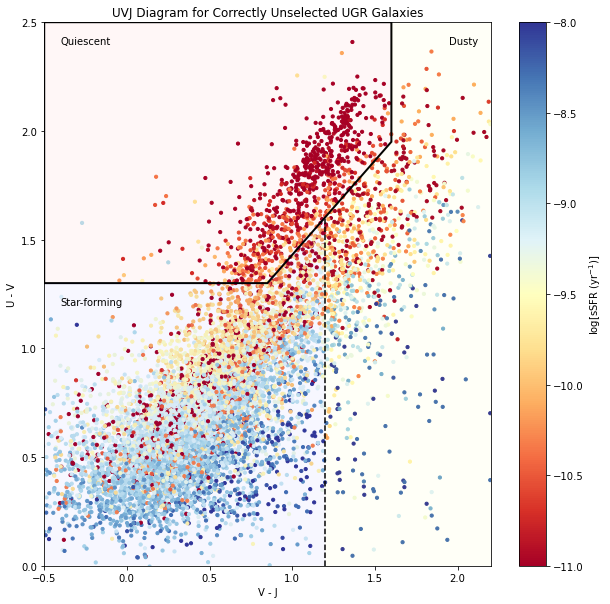

In [263]:
plot_uvj_categories(correct_nonugr_identification_df, 'Correctly Unselected')

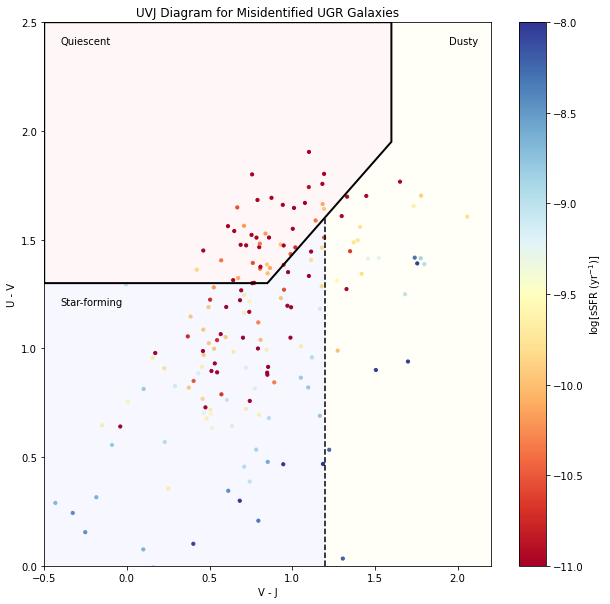

In [264]:
plot_uvj_categories(misidentification_df, 'Misidentified')

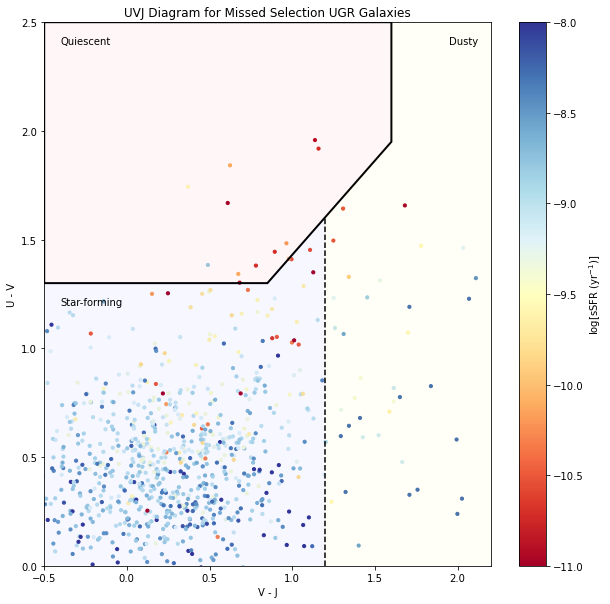

In [265]:
plot_uvj_categories(missed_selection_df, 'Missed Selection')

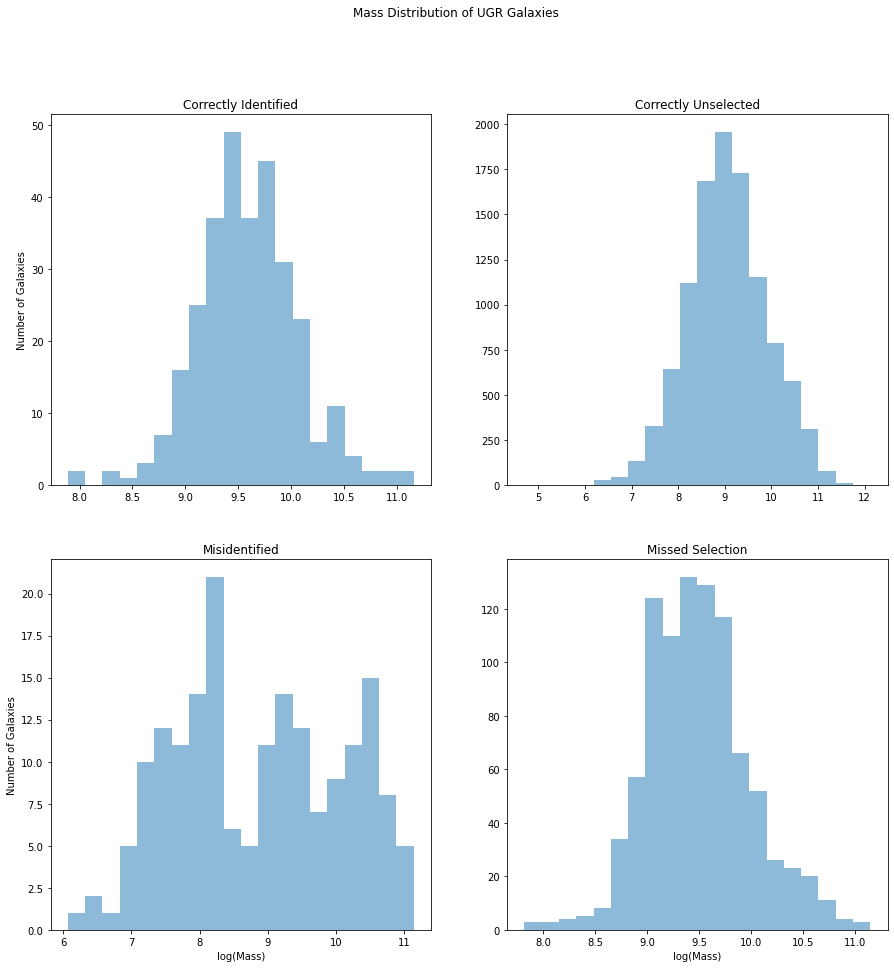

In [266]:
# Now do a subplot so we can see these all side by side - visualise the lmass distribution
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle('Mass Distribution of UGR Galaxies')
axs[0, 0].hist(correct_ugr_identification_df['lmass'], bins=20, alpha=0.5, label='Correctly Identified')
axs[0, 0].set_title('Correctly Identified')

axs[0, 1].hist(correct_nonugr_identification_df['lmass'], bins=20, alpha=0.5, label='Correctly Unselected')
axs[0, 1].set_title('Correctly Unselected')
axs[1, 0].hist(misidentification_df['lmass'], bins=20, alpha=0.5, label='Misidentified')
axs[1, 0].set_title('Misidentified')
axs[1, 1].hist(missed_selection_df['lmass'], bins=20, alpha=0.5, label='Missed Selection')
axs[1, 1].set_title('Missed Selection')

# Set labels for shared y-axis
for ax in axs[:, 0]:
    ax.set_ylabel('Number of Galaxies')

# Set labels for shared x-axis
for ax in axs[1, :]:
    ax.set_xlabel('log(Mass)')

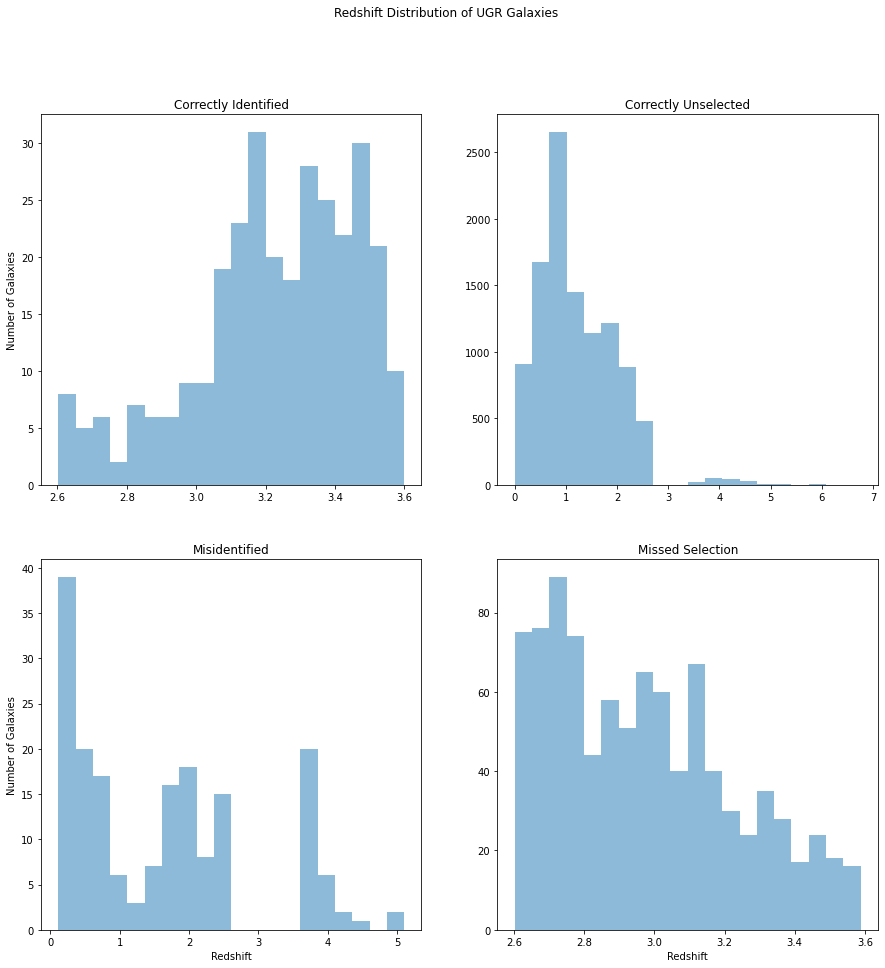

In [267]:
# side note we want to do two things - 1 for the misidentified agn, we want to check the redshift distribution 
# and for the missed selection we want to check the redshift distribution

# similarly to how we checked for the distribution of lmass, we can check the redshift distribution of all categories
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle('Redshift Distribution of UGR Galaxies')
axs[0, 0].hist(correct_ugr_identification_df['z_peak'], bins=20, alpha=0.5, label='Correctly Identified')
axs[0, 0].set_title('Correctly Identified')

axs[0, 1].hist(correct_nonugr_identification_df['z_peak'], bins=20, alpha=0.5, label='Correctly Unselected')
axs[0, 1].set_title('Correctly Unselected')
axs[1, 0].hist(misidentification_df['z_peak'], bins=20, alpha=0.5, label='Misidentified')
axs[1, 0].set_title('Misidentified')
axs[1, 1].hist(missed_selection_df['z_peak'], bins=20, alpha=0.5, label='Missed Selection')
axs[1, 1].set_title('Missed Selection')

# Set labels for shared y-axis
for ax in axs[:, 0]:
    ax.set_ylabel('Number of Galaxies')

# Set labels for shared x-axis
for ax in axs[1, :]:
    ax.set_xlabel('Redshift')


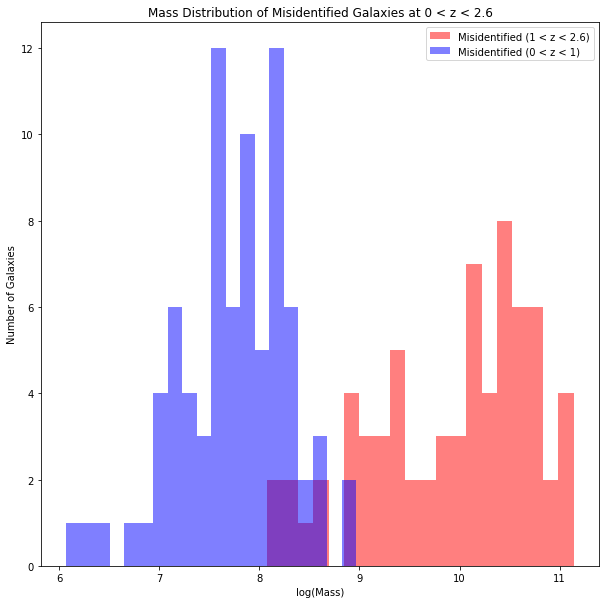

In [268]:
# further investigate the misidentified category at 0 < z < 2.6 - find the distribution of masses
misidentification_lowz1_df = misidentification_df[(misidentification_df['z_peak'] > 1 ) & (misidentification_df['z_peak'] < 2.6)]
misidentification_lowz26_df = misidentification_df[(misidentification_df['z_peak'] > 0 ) & (misidentification_df['z_peak'] <= 1)]

# plot the mass distribution of the misidentified category at 0 < z < 2.6
plt.figure(figsize=(10, 10))
plt.hist(misidentification_lowz1_df['lmass'], bins=20, alpha=0.5, label='Misidentified (1 < z < 2.6)', color='r')
plt.hist(misidentification_lowz26_df['lmass'], bins=20, alpha=0.5, label='Misidentified (0 < z < 1)', color='b')
plt.xlabel('log(Mass)')
plt.ylabel('Number of Galaxies')
plt.title('Mass Distribution of Misidentified Galaxies at 0 < z < 2.6')
plt.legend()
plt.show()


Text(0.5, 1.0, 'UGR Diagram for the COSMOS Field')

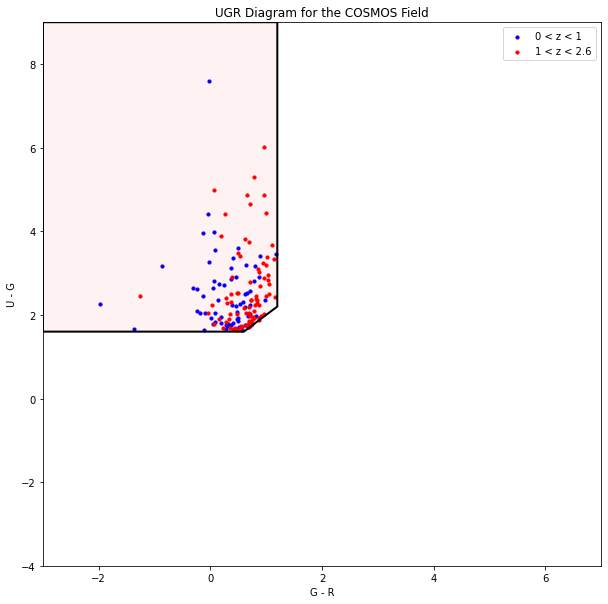

In [269]:
# Investigate where these two sets of galaxies sit on the UGR colour space, and ultimately the UVJ diagram
# First the UGR colour space
# setup colour indicies
ug_lowz1 = misidentification_lowz1_df['u_mag'] - misidentification_lowz1_df['g_mag']
gr_lowz1 = misidentification_lowz1_df['g_mag'] - misidentification_lowz1_df['r_mag']

ug_lowz26 = misidentification_lowz26_df['u_mag'] - misidentification_lowz26_df['g_mag']
gr_lowz26 = misidentification_lowz26_df['g_mag'] - misidentification_lowz26_df['r_mag']


# Plot the UGR diagram for the misidentified category at 0 < z < 2.6
plt.figure(figsize=(10, 10))
plt.scatter(gr_lowz1, ug_lowz1, c='b', label="0 < z < 1", s=10)
plt.scatter(gr_lowz26, ug_lowz26, c='r', label="1 < z < 2.6", s=10)
plt.xlim(-3, 7)
plt.ylim(-4, 9)
U_rule = [[1.2,9], [1.2,2.2], [0.6,1.6], [-3,1.6], [-3,9]]
plt.gca().add_patch(plt.Polygon(U_rule, closed=True, fill=True, facecolor=(1,0,0,0.05), edgecolor=(0,0,0,1), linewidth=2, linestyle='solid')) # This looks like the correct U dropout technique
plt.ylabel('U - G')
plt.xlabel('G - R')
plt.legend()
plt.title('UGR Diagram for the COSMOS Field')

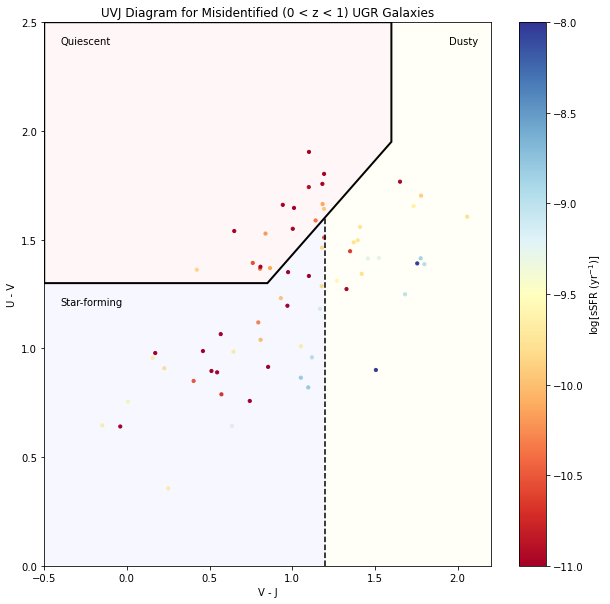

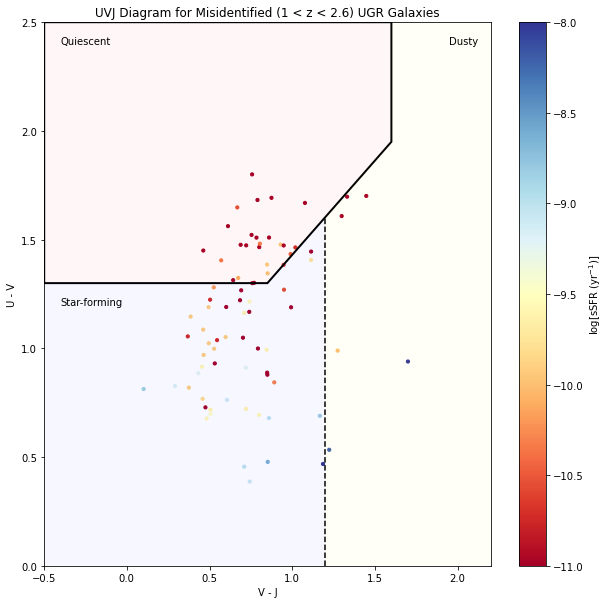

In [270]:
# Similarly we can see where these two sets of galaxies sit on the UVJ diagram
# Plotting the UVJ diagram for the misidentified category at 0 < z < 2.6

# setup the UVJ colour indicies
uv_lowz1 = misidentification_lowz1_df['rf_u_mag'] - misidentification_lowz1_df['rf_v_mag']
vj_lowz1 = misidentification_lowz1_df['rf_v_mag'] - misidentification_lowz1_df['rf_j_mag']

uv_lowz26 = misidentification_lowz26_df['rf_u_mag'] - misidentification_lowz26_df['rf_v_mag']
uv_lowz26 = misidentification_lowz26_df['rf_v_mag'] - misidentification_lowz26_df['rf_j_mag']


# Plot the UVJ diagram for the misidentified category at 0 < z < 2.6
plot_uvj_categories(misidentification_lowz1_df, 'Misidentified (0 < z < 1)')
plot_uvj_categories(misidentification_lowz26_df, 'Misidentified (1 < z < 2.6)')

Text(0.5, 1.0, 'Mass Distribution of Missed Selection Galaxies at 2.6 < z < 3.6')

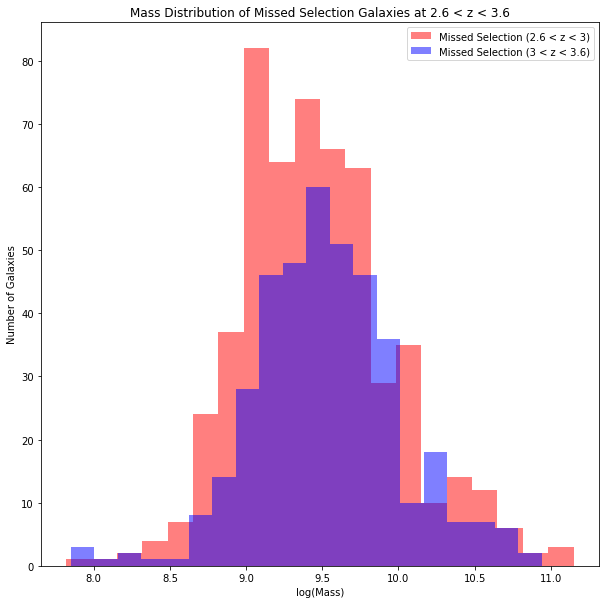

In [271]:
# We can similarly investigate the missed selection category at 2.6 < z < 3.6 - in bins of 2.6 to 3 and 3 to 3.6, noting that there is a lower amount of galaxies in the 3 to 3.6 range
missed_selection_midz_df = missed_selection_df[(missed_selection_df['z_peak'] > 2.6 ) & (missed_selection_df['z_peak'] < 3)]
missed_selection_highz_df = missed_selection_df[(missed_selection_df['z_peak'] >= 3 ) & (missed_selection_df['z_peak'] <= 3.6)]

# plot the mass distribution of the missed selection category at 2.6 < z < 3
plt.figure(figsize=(10, 10))
plt.hist(missed_selection_midz_df['lmass'], bins=20, alpha=0.5, label='Missed Selection (2.6 < z < 3)', color='r')
plt.hist(missed_selection_highz_df['lmass'], bins=20, alpha=0.5, label='Missed Selection (3 < z < 3.6)', color='b')
plt.xlabel('log(Mass)')
plt.ylabel('Number of Galaxies')
plt.legend()
plt.title('Mass Distribution of Missed Selection Galaxies at 2.6 < z < 3.6') # note the slight skew toward lower mass in the 2.6 to 3 range

Text(0.5, 1.0, 'UGR Diagram for the COSMOS Field')

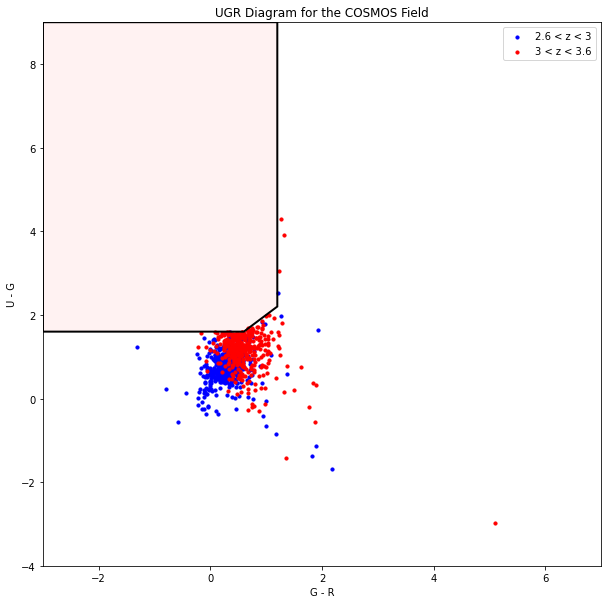

In [272]:
# Now we can investigate both of these redshift bins in UGR and UVJ space
# First the UGR colour space
# setup colour indicies
ug_midz = missed_selection_midz_df['u_mag'] - missed_selection_midz_df['g_mag']
gr_midz = missed_selection_midz_df['g_mag'] - missed_selection_midz_df['r_mag']

# setup colour indicies
ug_highz = missed_selection_highz_df['u_mag'] - missed_selection_highz_df['g_mag']
gr_highz = missed_selection_highz_df['g_mag'] - missed_selection_highz_df['r_mag']


# Plot the UGR diagram for the missed selection category at 2.6 < z < 3
plt.figure(figsize=(10, 10))
plt.scatter(gr_midz, ug_midz, c='b', label="2.6 < z < 3", s=10)
plt.scatter(gr_highz, ug_highz, c='r', label="3 < z < 3.6", s=10)
plt.xlim(-3, 7)
plt.ylim(-4, 9)
U_rule = [[1.2,9], [1.2,2.2], [0.6,1.6], [-3,1.6], [-3,9]]
plt.gca().add_patch(plt.Polygon(U_rule, closed=True, fill=True, facecolor=(1,0,0,0.05), edgecolor=(0,0,0,1), linewidth=2, linestyle='solid')) # This looks like the correct U dropout technique
plt.ylabel('U - G')
plt.xlabel('G - R')
plt.legend()
plt.title('UGR Diagram for the COSMOS Field')


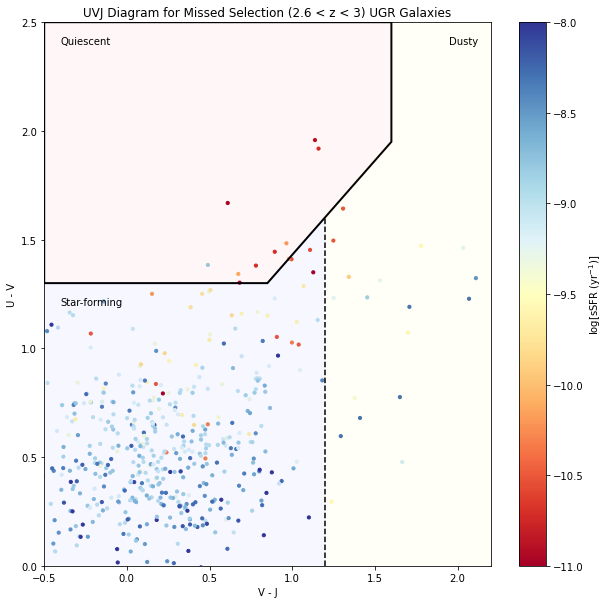

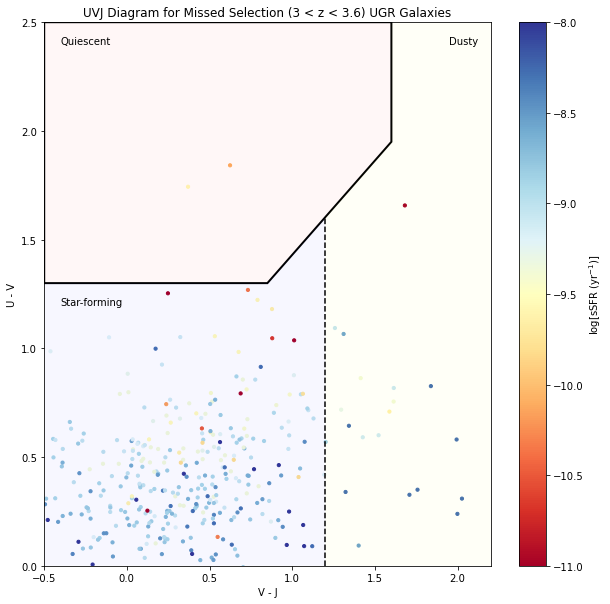

In [273]:
# Plotting the UVJ diagram for the missed selection category at 2.6 < z < 3
plot_uvj_categories(missed_selection_midz_df, 'Missed Selection (2.6 < z < 3)')
plot_uvj_categories(missed_selection_highz_df, 'Missed Selection (3 < z < 3.6)')

### Thoughts and Questions
There may be quite a lot going on based on the above images, we can consider a few questions to help guide our investigation:
1. Is this selection technique better at determining redshifts for galaxies at higher redshifts or lower redshifts? - Why would this be?
2. In investigating this colour selection technique, is the sample more skewed towards higher redshifts or lower redshifts? - Why would this be?
3. What are the implications of this selection technique being more skewed towards higher redshifts or lower redshifts?
4. In particular, the misidentified galaxies were higher amonst quite low redshifts, in particular between 0 and 1 Why would this be?
5. This technique correctly misses galaxies at a redshift of around 1 to 1.5, why is this effectively ommiting galaxies in this range
6. How do the above questions connect to the Lyman Break technique and the physics behind the lyman limit.
7. For z < 1 < 2.6 the misidentified galaxies are sitting in a spread between quiescent and starforming on the UVJ - however their logsSFR is alow, indicating dead galaxies. Why quiescent galaxies contamininating the source? - i.e potential ellpticals?
8. For galaxies that have been missed, what characteristics do they have in common? - i.e. are they all star forming, or are they all quiescent?
9. What are the trends across particular redshfit bins? - i.e. are there more missed galaxies at higher redshifts or lower redshifts?

## Part 2: Investigating Redshift Determination using Simulated Data from GALSEDATLAS.
Now we have investigated the ZFOURGE COSMOS data set, we can now investigate the Lyman Break technique using simulated data. The simulated data is from the GALSEDATLAS and SWIRE templates. To read in the templates we need to make use of passband filters that correspond to the filters used in the ZFOURGE Survey. These filters are the Paranal_OmegaCAM filters from the SDSS. From the templates we can artificially redshift the SEDs to investigate the Lyman Break, ultimately we can compare this against the ZFOURGE COSMOS data set to confirm the results.

# TODO - for starters
* Read in all the SED templates
* Use filter profiles to analyze the SED templates - i.e. UGR filters from the ZFOURGE Survey: VST Omegacam SDSS U, G and R filters. - additionally we can use UVJ filters, potentially? (explore this)
* Redshift the SED templates in increments of 0.1 from 0 to 4
* Plot the SED templates
* Investigate the Lyman Break
* Compare the results to the ZFOURGE COSMOS data set

In [274]:
# Begin my importing the the SED templates
galsedatlas_file = os.path.join('datasets', 'templates', 'hlsp_galsedatlas_multi_multi_all_multi_v1_cat.fits')

# Read in the SED templates
galsedatlas_fits = fits.open(galsedatlas_file)

# Check what the particular fits file contains - To eplore this we can use the info() method.
galsedatlas_fits.info()

Filename: datasets\templates\hlsp_galsedatlas_multi_multi_all_multi_v1_cat.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      10   ()      
  1  photometry    1 BinTableHDU    121   129R x 55C   [15A, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   
  2  photometry_minus_a    1 BinTableHDU    121   129R x 55C   [15A, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   
  3  summary       1 BinTableHDU     35   129R x 12C   [15A, D, D, 11A, 4A, 6A, D, D, D, D, K, D]   
  4  extinction    1 BinTableHDU     67   129R x 28C   [15A, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   
  5  NGC_4450_spec    1 BinTableHDU     32   2364R x 4C   [D, D, D, K]   
  6  UGC_04881_spec    1 Bi

In [275]:
# we can see that the file contains a table with the SED templates, photometry, extinction, and a summary. 
# We are interested in the SED templates which occur from index 5 to 134.
# We can read in the SED templates as a np array
galsedatlas_data_example = galsedatlas_fits[5].data

In [276]:
galsedatlas_data_example

FITS_rec([(1.0004000e+02, 5.8346e-18, 1.0069000e+02, 0),
          (1.0190000e+02, 7.1451e-18, 1.0257000e+02, 0),
          (1.0403000e+02, 8.0539e-18, 1.0471000e+02, 0), ...,
          (3.4385584e+05, 4.2211e-17, 3.4609709e+05, 3),
          (3.4569439e+05, 4.7657e-17, 3.4794762e+05, 3),
          (3.4753409e+05, 7.6478e-17, 3.4979931e+05, 3)],
         dtype=(numpy.record, [('rest_wavelength', '>f8'), ('flux_density', '>f8'), ('observed_wavelength', '>f8'), ('source', '>i8')]))

In [277]:
# We can explore how the passbands work, by importing the passbands  for the UGR colours
pb_u = os.path.join('datasets', 'filters', 'Paranal_OmegaCAM.u_SDSS.dat')
pb_g = os.path.join('datasets', 'filters', 'Paranal_OmegaCAM.g_SDSS.dat')
pb_r = os.path.join('datasets', 'filters', 'Paranal_OmegaCAM.r_SDSS.dat')

# Similarly we can also read in the passbands for the UVJ colours
pb_U = os.path.join('datasets', 'filters', 'Generic_Johnson.U.dat')
pb_V = os.path.join('datasets', 'filters', 'Generic_Johnson.V.dat')
pb_J = os.path.join('datasets', 'filters', '2MASS_2MASS.J.dat')

# Read in the passbands, using astLib
pb_u = astSED.Passband(pb_u, normalise=True)
pb_g = astSED.Passband(pb_g, normalise=True)
pb_r = astSED.Passband(pb_r, normalise=True)

pb_U = astSED.Passband(pb_U, normalise=True)
pb_V = astSED.Passband(pb_V, normalise=True)
pb_J = astSED.Passband(pb_J, normalise=True)


In [278]:
# We can now check the effect wavelength of the passbands on the SED templates
print("For the Paranal OmegaCAM Filters:")
print("Effective Wavelength of the u Band is", pb_u.effectiveWavelength())
print("Effective Wavelength of the g Band is", pb_g.effectiveWavelength())
print("Effective Wavelength of the r Band is", pb_r.effectiveWavelength())
print("\nFor the 2Mass and Johnson Filters:")
print("Effective Wavelength of the U Band is", pb_U.effectiveWavelength())
print("Effective Wavelength of the V Band is", pb_V.effectiveWavelength())
print("Effective Wavelength of the J Band is", pb_J.effectiveWavelength())

For the Paranal OmegaCAM Filters:
Effective Wavelength of the u Band is 3569.6226123486795
Effective Wavelength of the g Band is 4711.992397306267
Effective Wavelength of the r Band is 6285.945598240397

For the 2Mass and Johnson Filters:
Effective Wavelength of the U Band is 3524.6565367276125
Effective Wavelength of the V Band is 5525.060451799561
Effective Wavelength of the J Band is 12393.093155655275


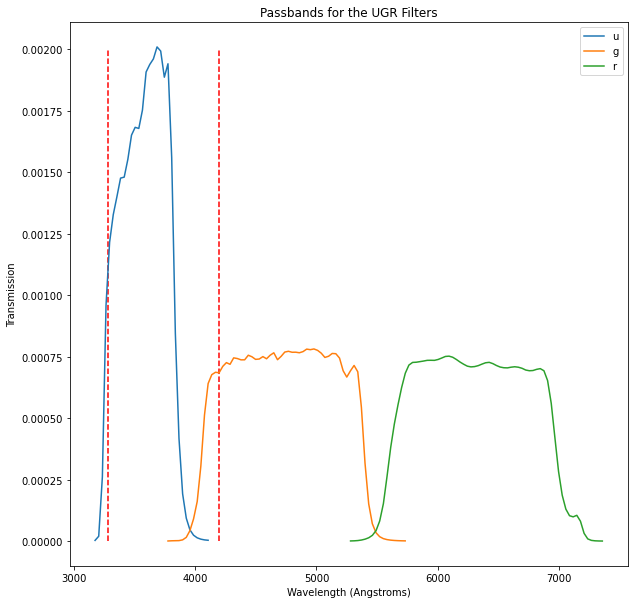

In [279]:
# We can now plot the passbands for the UGR
u_arr = np.array(pb_u.asList())
g_arr = np.array(pb_g.asList())
r_arr = np.array(pb_r.asList())

plt.figure(figsize=(10, 10))
plt.plot(u_arr[:, 0], u_arr[:,1], label='u')
plt.plot(g_arr[:, 0], g_arr[:,1], label='g')
plt.plot(r_arr[:, 0], r_arr[:,1], label='r')
plt.title("Passbands for the UGR Filters")
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Transmission')
plt.legend()


# additionally as we are investigating the lyman break, we can plot the lyman break and where it would be redshifted too
# we can do this using the appropriate equation: λ = λ_0 * (1 + z)
lyman_break = 912
lyman_break_z26 = lyman_break * (1 + 2.6)
lyman_break_z36 = lyman_break * (1 + 3.6)

# Plotting this on the same graph as the passbands
plt.vlines(lyman_break_z26, 0, 0.002, color='r',linestyle="--", label='Lyman Break (z = 2.6)')
plt.vlines(lyman_break_z36, 0, 0.002, color='r',linestyle="--", label='Lyman Break (z = 3.6)')

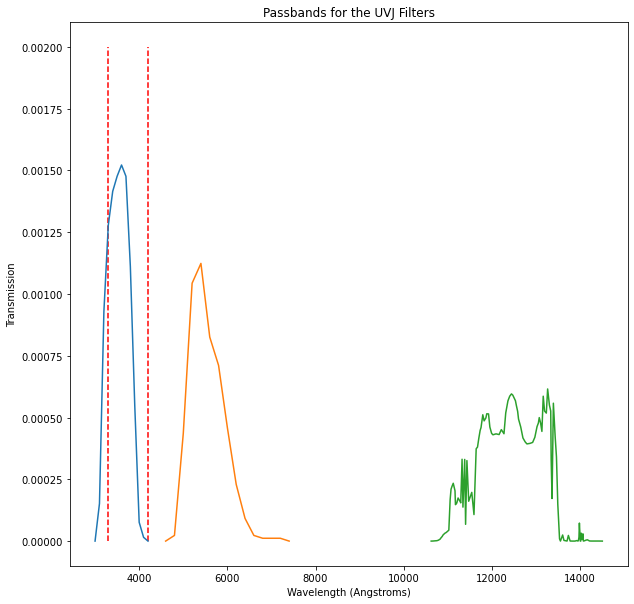

In [280]:
# We can also plot the passbands for the UVJ
U_arr = np.array(pb_U.asList())
V_arr = np.array(pb_V.asList())
J_arr = np.array(pb_J.asList())

plt.figure(figsize=(10, 10))
plt.plot(U_arr[:, 0], U_arr[:,1], label='U')
plt.plot(V_arr[:, 0], V_arr[:,1], label='V')
plt.plot(J_arr[:, 0], J_arr[:,1], label='J')
plt.title("Passbands for the UVJ Filters")
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Transmission')


# additionally as we are investigating the lyman break, we can plot the lyman break and where it would be redshifted too
# we can do this using the appropriate equation: λ = λ_0 * (1 + z)
lyman_break = 912
lyman_break_z26 = lyman_break * (1 + 2.6)
lyman_break_z36 = lyman_break * (1 + 3.6)

# Plotting this on the same graph as the passbands
plt.vlines(lyman_break_z26, 0, 0.002, color='r',linestyle="--", label='Lyman Break (z = 2.6)')
plt.vlines(lyman_break_z36, 0, 0.002, color='r',linestyle="--", label='Lyman Break (z = 3.6)')

In [293]:
# Now we must look at the SED templates and the passbands to calculate the UGR and UVJ colours for the SED templates. Using the astLib library we can 
for n in range(5, 134):
    # Get the SED template
    sed = galsedatlas_fits[n].data
    # Create an astSED object
    sed = astSED.SED(sed['observed_wavelength'], sed['flux_density'])
    # Calculate the UGR and UVJ colours
    sed
    # Print the results
   # print(f"SED Template {n} has UGR Colour: {ugr} and UVJ Colour: {uvj}")